In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
class IterationData:
    """
    A class to load in the data from each iteration to an object in a readable form for later visualisation    
    """
    def __init__(self, iteration):
        # self.folder_path = os.path.join('..\ArchivedData', 'WhyNNETdoesntwork\\')
        self.folder_path = r'Data\Daf\\'
        self.decimal_places = 3
        self.training_path = self.folder_path + 'TrainingExamples' + str(iteration)
        self.nnet_loss_path = self.folder_path + 'NNetLosses' + str(iteration)
        self.x_threshold = 2.4
        self.theta_threshold_radians = 0.21
        
        class ReturnClass(dict):
            def __getattr__(self, name):
                return self[name]
        
        with open(self.training_path + '.csv', 'r', newline='') as f:
            row_count = sum(1 for row in f)
        self.episodes = int(row_count/4)
        
        self.training_examples = ReturnClass()  # dict of {ep1: dataframe[2Dstate, TrueValue, PolicyValue, MCTSAction, PolicyAction], ep2: ...}
        self.state_2ds = np.load(self.training_path +'.npz')
        self.read_examples()
        
        self.nnet_losses = self.read_nnet_losses()
    
    def read_examples(self):
        step_counter = 0
        for episode in range(self.episodes):
            
            rows = [4*episode, 4*episode+1, 4*episode+2, 4*episode+3]

            # only pick out relevent rows (because others are different lengths -> can't be read)
            episode_data = pd.read_csv(self.training_path + '.csv', header=None, skiprows=lambda x: x not in rows).transpose()
            episode_data.columns = ['TrueValue', 'PolicyValue', 'MCTSAction', 'PolicyAction']
            episode_data.TrueValue = episode_data.TrueValue.astype(float).round(self.decimal_places)
            episode_data.PolicyValue = episode_data.PolicyValue.astype(float).round(self.decimal_places)

            # Split arrays and convert to integers
            episode_data.MCTSAction = episode_data.MCTSAction.apply(lambda x: x[1:-1].split(','))
            episode_data.MCTSAction = episode_data.MCTSAction.apply(lambda x: [round(float(elm), self.decimal_places) for elm in x])
            episode_data.PolicyAction = episode_data.PolicyAction.apply(lambda x: x[1:-1].split(','))
            episode_data.PolicyAction = episode_data.PolicyAction.apply(lambda x: [round(float(elm), self.decimal_places) for elm in x])

            # if we want extra columns then this is the way to seperate the arr
            # print(list(zip(*dataframe.MCTSAction.values)))            
            
            # add a reference to the stated2D for each step
            episode_states = list(self.state_2ds)[step_counter:step_counter+episode_data.index[-1]+1]
            step_counter += episode_data.index[-1]+1          
            episode_data['State2D'] = episode_states
            
            # and then add the whole dataframe to the dict
            self.training_examples['Episode'+str(episode)] = episode_data
        
    def read_nnet_losses(self):
        losses = pd.read_csv(self.nnet_loss_path + '.csv', names=['Action', 'Value', 'Total'])
        return losses
    
    def get_state_2d(self, episode, step):
        episode = 'Episode'+str(episode)
        return self.state_2ds[self.training_examples[episode].State2D.values[step]]

    def print_state_2d(self, state_2d):
        # Plot MCTS action, action policy and values associated?
        
        fig = plt.figure()
        axes = fig.add_axes([0, 0, 1, 1])  # add an axis object to the figure
        
        # returns a colourAxisImage, that we need to map the colourbar to the figure
        mapable = axes.imshow(state_2d, extent=[-self.x_threshold, self.x_threshold, -self.theta_threshold_radians,
                                     self.theta_threshold_radians], cmap='jet', aspect='auto')
        
        axes.set_xlabel("X-Position")
        axes.set_ylabel("Angular Position")
        fig.colorbar(mapable)
        return fig, axes
        
    
    def plot_episode(self, episode, colour = 'blue', fig_axes=None):
        # extract data for values and actions
        policy_values = self.training_examples['Episode'+str(episode)].PolicyValue
        true_values = self.training_examples['Episode'+str(episode)].TrueValue
        
        policy_actions = self.training_examples['Episode'+str(episode)].PolicyAction.values
        mcts_actions = self.training_examples['Episode'+str(episode)].MCTSAction.values
        
        policy_actions = list(zip(*policy_actions))
        mcts_actions = list(zip(*mcts_actions))
        
        # check if subplots already exist
        if fig_axes is None:
            fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(17, 12))
        else:
            fig, axes = fig_axes[0], fig_axes[1]
            
        
        # Value Subplot
        axes[0].plot(policy_values, color=colour, linestyle='--', label='Policy Values Ep: '+str(episode))
        axes[0].plot(true_values, color=colour, linestyle='-', label='True Values Ep: '+str(episode))
        axes[0].legend()
        axes[0].set_ylabel('State Value')
        
        # Action Subplot
        axes[1].plot(policy_actions[0], color=colour, linestyle='--', label='Policy Actions Ep: '+str(episode))
        axes[1].plot(mcts_actions[0], color=colour, linestyle='-', label='MCTS Actions Ep: '+str(episode))
        axes[1].legend()
        axes[1].set_ylabel('Probability of Going Left')
        axes[1].set_xlabel('Steps')
        
        return fig, axes
    
    def plot_nnet_losses(self):
        fig = plt.figure(figsize=(17, 7))
        axes = fig.add_axes([0, 0, 1, 1])
        
        axes.plot(self.nnet_losses)
        axes.legend(['Action', 'Value', 'Total'])
        axes.set_xlabel('Batches (size 8)')
        axes.set_ylabel('Loss')
        
        
        

   TrueValue  PolicyValue      MCTSAction    PolicyAction  State2D
0     -0.094       -0.035  [0.517, 0.483]  [0.506, 0.494]  arr_201
1     -0.115       -0.035      [0.5, 0.5]  [0.506, 0.494]  arr_202
2     -0.141       -0.028    [0.51, 0.49]  [0.506, 0.494]  arr_203
3     -0.170       -0.028  [0.509, 0.491]  [0.506, 0.494]  arr_204
4     -0.202       -0.027  [0.619, 0.381]  [0.507, 0.493]  arr_205


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._axes.Axes at 0x258ff31e710>)

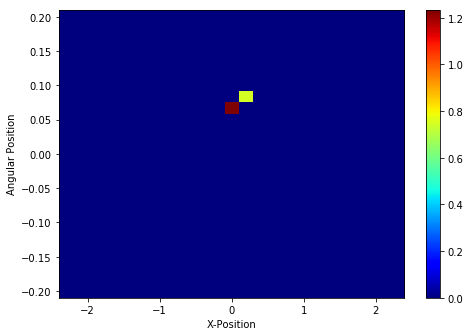

In [9]:
te0 = IterationData(iteration = 0)
te1 = IterationData(iteration = 1)
#te2 = IterationData(iteration = 2)
#te3 = IterationData(iteration = 3)
#te4 = IterationData(iteration = 4)
#te5 = IterationData(iteration = 5)

print(te0.training_examples['Episode1'].head())
#print(te3.training_examples.Episode1.State2D.values[0])
te0.print_state_2d(te0.get_state_2d(episode=0, step=4))
# print(stock_ids)

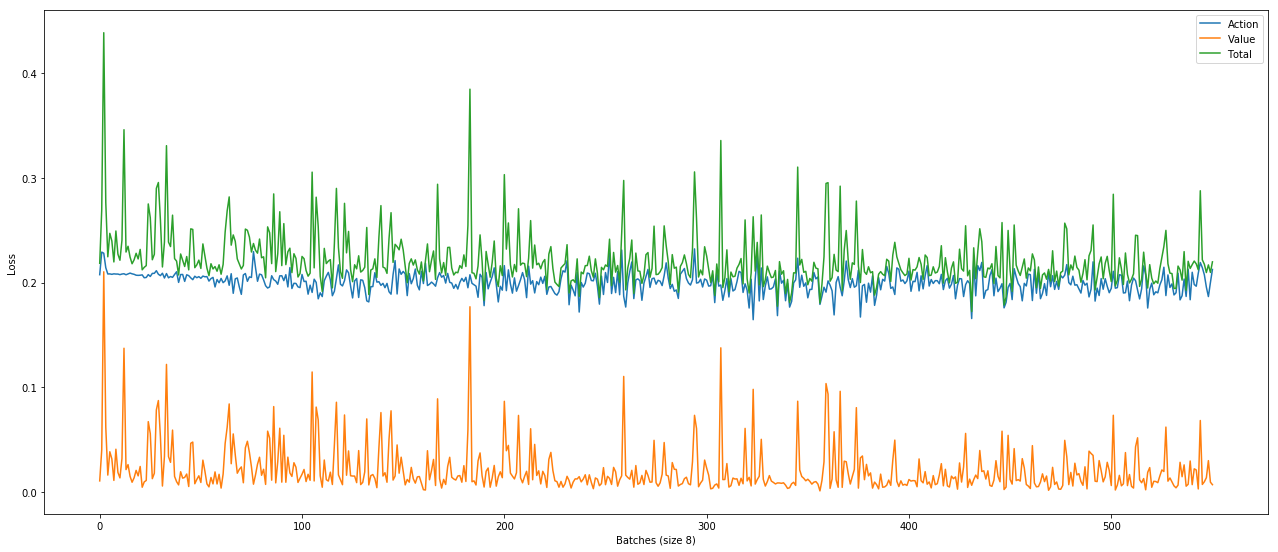

In [11]:
te1.plot_nnet_losses()

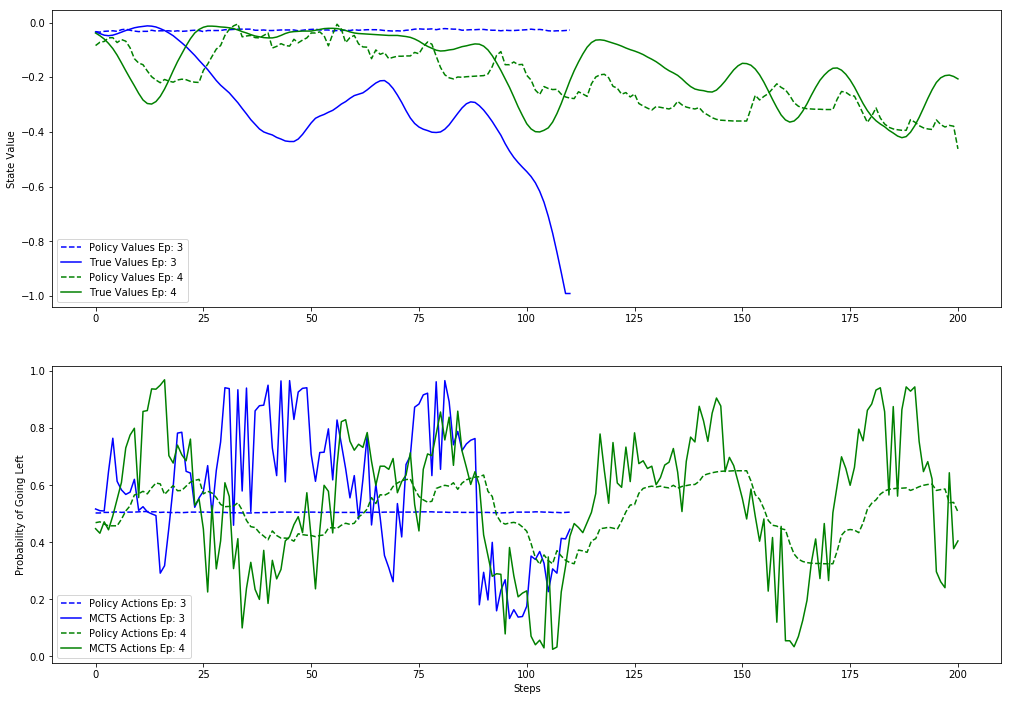

In [12]:
fig, ax = te0.plot_episode(episode=3, colour='blue')
fig, ax = te1.plot_episode(episode=4, colour='green', fig_axes=(fig, ax))
# fig_end, ax = te5.plot_episode(episode=4, colour='orange', fig_axes=(fig, ax))
